# 3. Modeling with US County granularity

Perhaps modeling at the state level doesn't produce insights at a useful granularity. We can easily construct a similar RUME at the county level and run the same simulations.

In [1]:
from epymorph.geography.us_census import CountyScope

scope = CountyScope.in_states_by_code(["AZ", "NM", "CO", "UT"], year=2020)

print(f"nodes: {scope.nodes}")
print(f"geoid (first 8): {scope.get_node_ids().tolist()[0:8]}")
print(f"geoid  (last 8): {scope.get_node_ids().tolist()[-8:]}")

nodes: 141
geoid (first 8): ['04001', '04003', '04005', '04007', '04009', '04011', '04012', '04013']
geoid  (last 8): ['49043', '49045', '49047', '49049', '49051', '49053', '49055', '49057']


## Centroids movement

Our first movement model is a simple distance kernel using node centroid coordinates (longitude/latitude).

Running simulation (BasicSimulator):
• 2020-01-01 to 2020-05-30 (150 days)
• 141 geo nodes
|####################| 100% 
Runtime: 10.502s


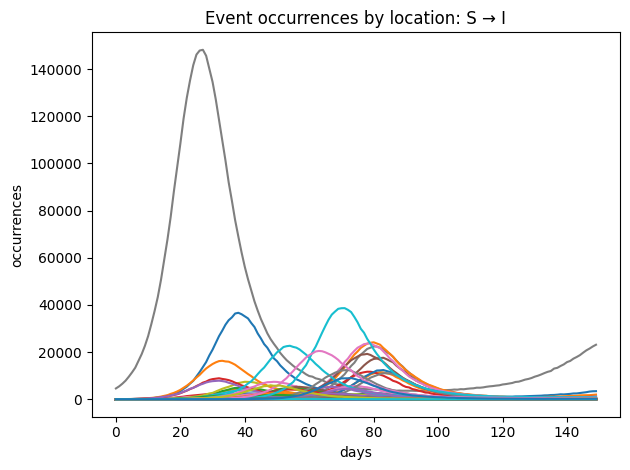

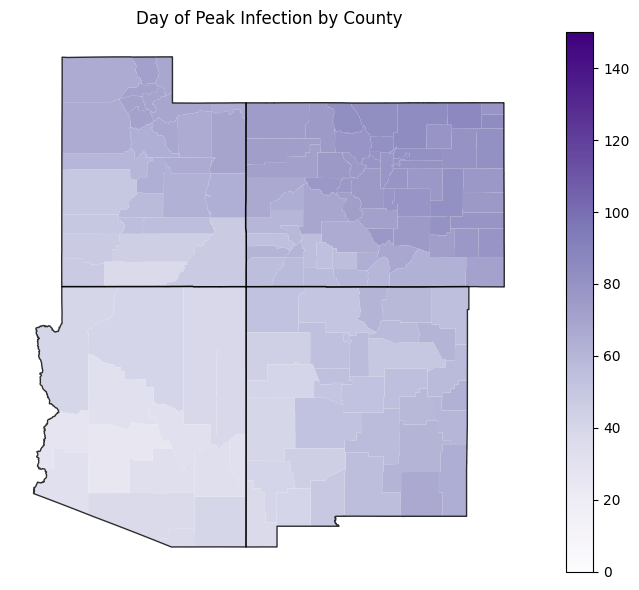

In [2]:
import numpy as np

from epymorph import *
from epymorph.adrio import acs5, us_tiger
from epymorph.plots import map_data_by_county

rume = SingleStrataRume.build(
    ipm=ipm_library["sirh"](),
    mm=mm_library["centroids"](),
    scope=scope,
    params={
        "beta": 0.45,
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "phi": 40.0,
        "population": acs5.Population(),
        "centroid": us_tiger.GeometricCentroid(),
    },
    time_frame=TimeFrame.of("2020-01-01", 150),
    # Initialize the infection in Maricopa County, Arizona with 10k individuals.
    # It's at index 7 because counties are ordered by FIPS code.
    init=init.SingleLocation(location=7, seed_size=10_000),
)

sim = BasicSimulator(rume)
with sim_messaging():
    output = sim.run()

EVENT_S_TO_I = rume.ipm.event_by_name("S->I")

plot_event(output, event_idx=EVENT_S_TO_I)

day_of_peak_infection = np.array(
    [
        # argmax gives us an index, but the index is equal to the tau step index
        # so just need to floor-div by number of tau steps to get day
        float(np.argmax(output.incidence[:, n, EVENT_S_TO_I])) // output.dim.tau_steps
        for n in range(scope.nodes)
    ]
)

map_data_by_county(
    scope=scope,
    data=day_of_peak_infection,
    title="Day of Peak Infection by County",
    vmin=0,
    vmax=output.dim.days,
    cmap="Purples",
    outline="states",
)

## Commuters movement

Now switch to a different movement model, incorporating the Census Bureau's ACS Commuting Flows data, and run the simulation again.

Running simulation (BasicSimulator):
• 2020-01-01 to 2020-05-30 (150 days)
• 141 geo nodes
|####################| 100% 
Runtime: 9.398s


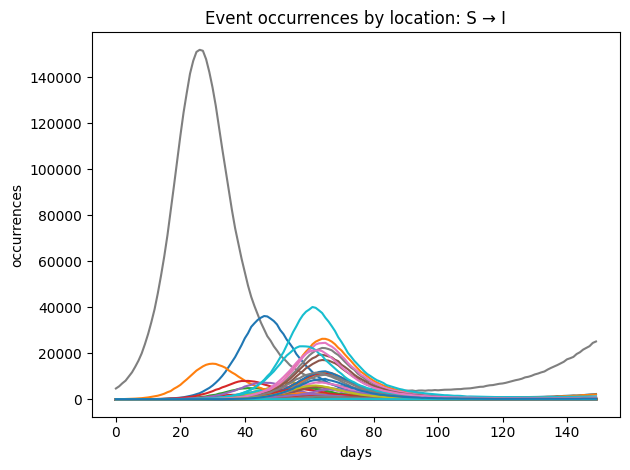

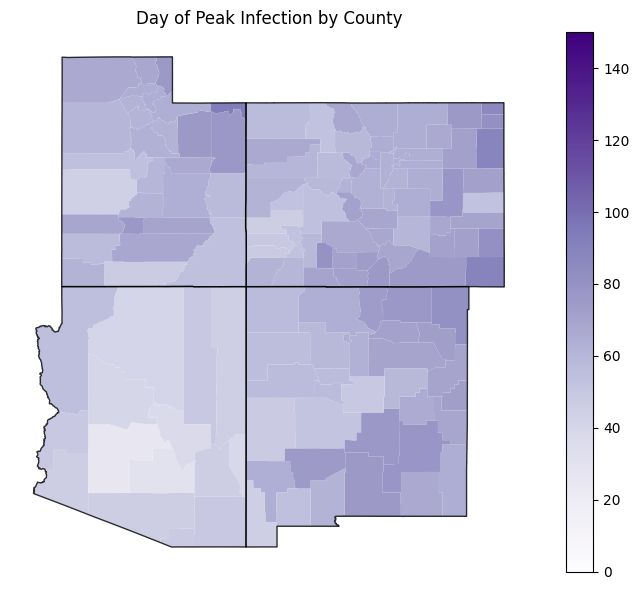

In [3]:
import numpy as np

from epymorph import *
from epymorph.adrio import acs5, commuting_flows, us_tiger
from epymorph.plots import map_data_by_county

rume = SingleStrataRume.build(
    ipm=ipm_library["sirh"](),
    mm=mm_library["pei"](),
    scope=scope,
    params={
        "beta": 0.45,
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "move_control": 0.9,
        "theta": 0.1,
        "population": acs5.Population(),
        "centroid": us_tiger.GeometricCentroid(),
        "commuters": commuting_flows.Commuters(),
    },
    time_frame=TimeFrame.of("2020-01-01", 150),
    # Initialize the infection in Maricopa County, Arizona with 10k individuals.
    init=init.SingleLocation(location=7, seed_size=10_000),
)

sim = BasicSimulator(rume)
with sim_messaging():
    output = sim.run()

EVENT_S_TO_I = rume.ipm.event_by_name("S->I")

plot_event(output, event_idx=EVENT_S_TO_I)

day_of_peak_infection = np.array(
    [
        # argmax gives us an index, but the index is equal to the tau step index
        # so just need to floor-div by number of tau steps to get day
        float(np.argmax(output.incidence[:, n, EVENT_S_TO_I])) // output.dim.tau_steps
        for n in range(scope.nodes)
    ]
)

map_data_by_county(
    scope=scope,
    data=day_of_peak_infection,
    title="Day of Peak Infection by County",
    vmin=0,
    vmax=output.dim.days,
    cmap="Purples",
    outline="states",
)